In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pyswarms as ps

In [2]:
# 1. Load the dataset
data = pd.read_csv('/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned_sensor_data.csv')

In [3]:
# Check if the first row contains indexes and adjust accordingly
if data.iloc[0, 0] == '0' and 'timestamp' not in data.columns:
    # Create column names based on the sample provided
    column_names = ['index', 'timestamp']
    column_names.extend([f'sensor_{i:02d}' for i in range(52)])
    column_names.append('machine_status')

    # Load the data again with proper column names
    data = pd.read_csv('your_dataset.csv', names=column_names)

    # Drop the index column if it exists
    if 'index' in data.columns:
        data = data.drop('index', axis=1)

# Display dataset info
print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (220320, 54)
             timestamp  Unnamed: 0  sensor_00  sensor_01  sensor_02  \
0  2018-04-01 00:00:00         0.0   2.465394   47.09201    53.2118   
1  2018-04-01 00:01:00         1.0   2.465394   47.09201    53.2118   
2  2018-04-01 00:02:00         2.0   2.444734   47.35243    53.2118   
3  2018-04-01 00:03:00         3.0   2.460474   47.09201    53.1684   
4  2018-04-01 00:04:00         4.0   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Handle missing values
# Note that sensor_15 has a very high number of missing values (220320)
# We have a few options:
# 1. Drop this column entirely
# 2. Use a more sophisticated imputation method
# 3. Use models that can handle missing values natively

print("\nHandling missing values...")

# Remove columns with extremely high missing values (e.g., >50% missing)
cols_to_drop = []
for col in data.columns:
    if col != 'machine_status' and col != 'timestamp':
        if data[col].isnull().sum() > len(data) * 0.5:
            cols_to_drop.append(col)

print(f"Dropping columns with >50% missing values: {cols_to_drop}")
data = data.drop(cols_to_drop, axis=1)


Missing values per column:
Series([], dtype: int64)

Handling missing values...
Dropping columns with >50% missing values: []


In [5]:
# For remaining columns, use median imputation (fast and robust)
if 'timestamp' in data.columns:
    X = data.drop(['timestamp', 'machine_status'], axis=1)
else:
    X = data.drop(['machine_status'], axis=1)

print("Using median imputation for remaining missing values...")
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame if needed
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Combine with the target variable and timestamp if needed
if 'timestamp' in data.columns:
    result_data = pd.concat([data[['timestamp']], X_imputed_df, data[['machine_status']]], axis=1)
else:
    result_data = pd.concat([X_imputed_df, data[['machine_status']]], axis=1)

# Save the cleaned dataset to CSV
output_path = "/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv"  # Replace with your desired path
result_data.to_csv(output_path, index=False)
print(f"Missing value handling complete. Cleaned dataset saved to {output_path}")

# Convert back to DataFrame to keep column names
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)


Using median imputation for remaining missing values...
Missing value handling complete. Cleaned dataset saved to /content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv


In [6]:
# Encode the target variable if needed
y = data['machine_status']
if y.dtype == object:  # If the target is categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y

Encoded machine status: {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.3, random_state=42)


In [9]:
# Encode the target variable if needed
y = data['machine_status']
if y.dtype == object:  # If the target is categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y

# Sample the dataset
sample_sizes = [100]  # You can adjust these sizes
print("\nChoosing sample sizes for experiments:")

for sample_size in sample_sizes:
    # Ensure sample_size doesn't exceed total dataset size
    sample_size = min(sample_size, len(X_imputed))

    # Randomly sample the data
    indices = np.random.choice(X_imputed.shape[0], sample_size, replace=False)
    X_sample = X_imputed[indices]
    y_sample = y_encoded[indices]

    print(f"\nExperiment with sample size: {sample_size}")

    # Split sampled data
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

    # Rest of the existing code remains the same from here...
    # (The PSO optimization, model training, etc. will now use these sampled datasets)

Encoded machine status: {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}

Choosing sample sizes for experiments:

Experiment with sample size: 100


In [10]:
# 2-3. Apply PSO for dimensionality reduction
# Prepare data for PSO
n_features = X_train.shape[1]
n_reduced_features = 20  # Target number of features to keep (similar to PCA)


In [11]:
# Define PSO fitness function
def f_per_particle(m, alpha=0.5):
    """
    Fitness function for feature selection:
    - m: binary mask representing selected/unselected features
    - alpha: parameter to balance between # of features and performance
    """
    # Get the subset of data using the binary mask
    if np.sum(m) == 0:
        # If no features are selected, return a very poor fitness
        return 999999

    # Get indices of selected features
    selected_features = np.where(m == 1)[0]

    # Use an SVM classifier to get accuracy - we'll use this as our measure
    # You can replace this with any model that can train quickly
    clf = SVR()

    # Train using selected features
    X_selected = X_train[:, selected_features]

    try:
        clf.fit(X_selected, y_train)
        y_pred = clf.predict(X_test[:, selected_features])
        mse = mean_squared_error(y_test, y_pred)

        # Our goal is to minimize MSE and the number of features
        return alpha * mse + (1.0 - alpha) * (np.sum(m) / n_features)
    except:
        return 999999

def f(x, alpha=0.5):
    """
    Fitness function for PSO optimization
    Takes a population of binary masks and returns an array of fitness values
    """
    n_particles = x.shape[0]
    fitness = np.zeros(n_particles)

    for i in range(n_particles):
        fitness[i] = f_per_particle(x[i], alpha)

    return fitness

In [18]:
# Measure computation time
start_time = time.time()

# Set up hyperparameters
options = {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}

# Initialize swarm
dimensions = n_features  # Number of features
optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=20)

# Get selected feature indices
selected_features = np.where(pos == 1)[0]
print(f"Selected features: {selected_features}")
print(f"Number of selected features: {len(selected_features)}")

2025-03-25 02:50:02,167 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.13
2025-03-25 02:50:03,997 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.12967339865095018, best pos: [0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]


Selected features: [ 1  3  4  5 13 19 20 30 33 34 36 41 48]
Number of selected features: 13


In [19]:
# Create reduced datasets
X_train_pso = X_train[:, selected_features]
X_test_pso = X_test[:, selected_features]
pso_time = time.time() - start_time

# Get PSO feature information
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'sensor_{i:02d}' for i in range(X_imputed.shape[1])]
selected_feature_names = [feature_names[i] for i in selected_features]

print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {len(selected_features)}")
print(f"PSO computation time: {pso_time:.4f} seconds")
print(f"Selected feature names: {selected_feature_names}")

Original features: 52
Reduced features: 13
PSO computation time: 5.0149 seconds
Selected feature names: ['sensor_00', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_12', 'sensor_19', 'sensor_20', 'sensor_30', 'sensor_33', 'sensor_34', 'sensor_36', 'sensor_41', 'sensor_48']


In [20]:
# 4-5. Train models on original dataset and calculate accuracy
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

original_results = {}
original_times = {}

for name, model in models.items():
    print(f"Training {name} on original dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    original_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    original_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")

Training Linear Regression on original dataset...
Linear Regression trained in 0.0262 seconds
Training SVM Regression on original dataset...
SVM Regression trained in 0.0059 seconds
Training Random Forest on original dataset...
Random Forest trained in 0.2991 seconds
Training Gradient Boosting on original dataset...
Gradient Boosting trained in 0.1537 seconds


In [21]:
# 6-7. Train models on reduced dataset and calculate accuracy
reduced_results = {}
reduced_times = {}

for name, model in models.items():
    print(f"Training {name} on reduced dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train_pso, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pso)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    reduced_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    reduced_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")

Training Linear Regression on reduced dataset...
Linear Regression trained in 0.0043 seconds
Training SVM Regression on reduced dataset...
SVM Regression trained in 0.0034 seconds
Training Random Forest on reduced dataset...
Random Forest trained in 0.2373 seconds
Training Gradient Boosting on reduced dataset...
Gradient Boosting trained in 0.1140 seconds


In [22]:
# 8. Display results
print("\n--- DIMENSIONALITY REDUCTION RESULTS (PSO) ---")
print(f"a) Features Reduced: {X_train.shape[1]} -> {len(selected_features)} ({X_train.shape[1] - len(selected_features)} features removed)")
print(f"b) PSO Computation Time: {pso_time:.4f} seconds")

# Display R2 values for all models
print("\nc) R-squared Values:")
for name in models.keys():
    print(f"   {name}: Original = {original_results[name]['R2']:.4f}, Reduced (PSO) = {reduced_results[name]['R2']:.4f}")

# Display model accuracies (using R2 as accuracy metric for regression)
print("\nd) Model Accuracy with Original Dataset (R2):")
for name, result in original_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {original_times[name]:.4f} seconds)")

print("\ne) Model Accuracy with PSO Reduced Dataset (R2):")
for name, result in reduced_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {reduced_times[name]:.4f} seconds)")



--- DIMENSIONALITY REDUCTION RESULTS (PSO) ---
a) Features Reduced: 52 -> 13 (39 features removed)
b) PSO Computation Time: 5.0149 seconds

c) R-squared Values:
   Linear Regression: Original = 0.7982, Reduced (PSO) = 0.9467
   SVM Regression: Original = -0.0975, Reduced (PSO) = 0.9478
   Random Forest: Original = 0.9589, Reduced (PSO) = 0.9726
   Gradient Boosting: Original = 0.9874, Reduced (PSO) = 1.0000

d) Model Accuracy with Original Dataset (R2):
   Linear Regression: 0.7982 (Training time: 0.0262 seconds)
   SVM Regression: -0.0975 (Training time: 0.0059 seconds)
   Random Forest: 0.9589 (Training time: 0.2991 seconds)
   Gradient Boosting: 0.9874 (Training time: 0.1537 seconds)

e) Model Accuracy with PSO Reduced Dataset (R2):
   Linear Regression: 0.9467 (Training time: 0.0043 seconds)
   SVM Regression: 0.9478 (Training time: 0.0034 seconds)
   Random Forest: 0.9726 (Training time: 0.2373 seconds)
   Gradient Boosting: 1.0000 (Training time: 0.1140 seconds)


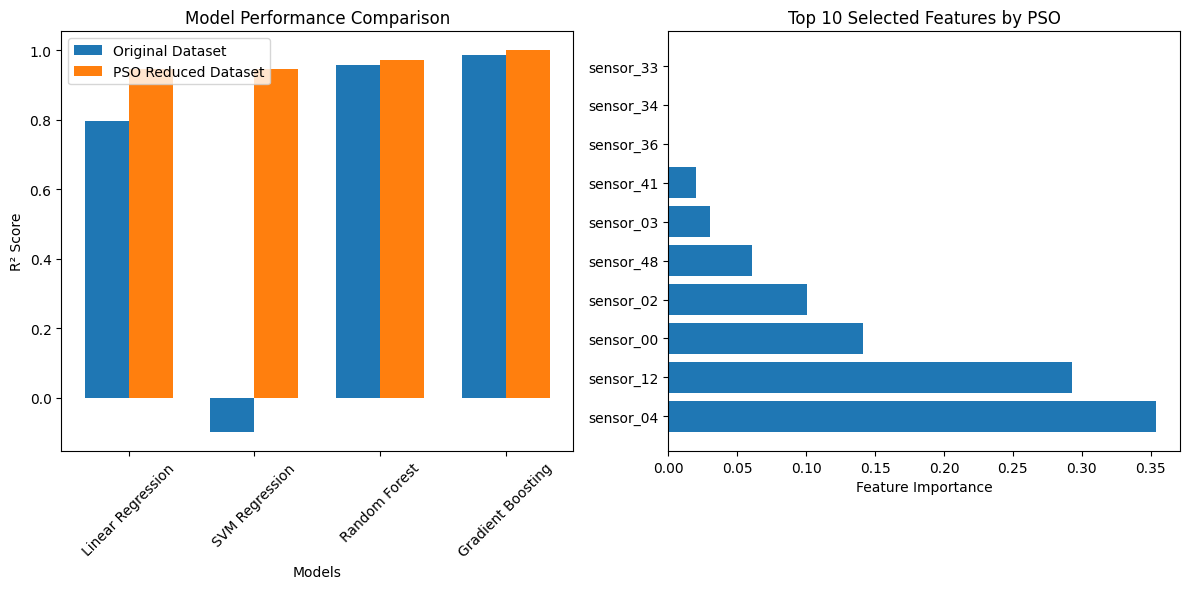


Performance Summary:
                   Original Dataset R²  PSO Reduced Dataset R²  R² Difference  \
Linear Regression             0.798193                0.946728       0.148535   
SVM Regression               -0.097531                0.947751       1.045282   
Random Forest                 0.958876                0.972553       0.013677   
Gradient Boosting             0.987369                1.000000       0.012631   

                   Original Training Time (s)  PSO Reduced Training Time (s)  \
Linear Regression                    0.026209                       0.004338   
SVM Regression                       0.005859                       0.003375   
Random Forest                        0.299091                       0.237342   
Gradient Boosting                    0.153691                       0.113971   

                   Time Savings (%)  
Linear Regression         83.448257  
SVM Regression            42.400814  
Random Forest             20.645702  
Gradient Boosting  

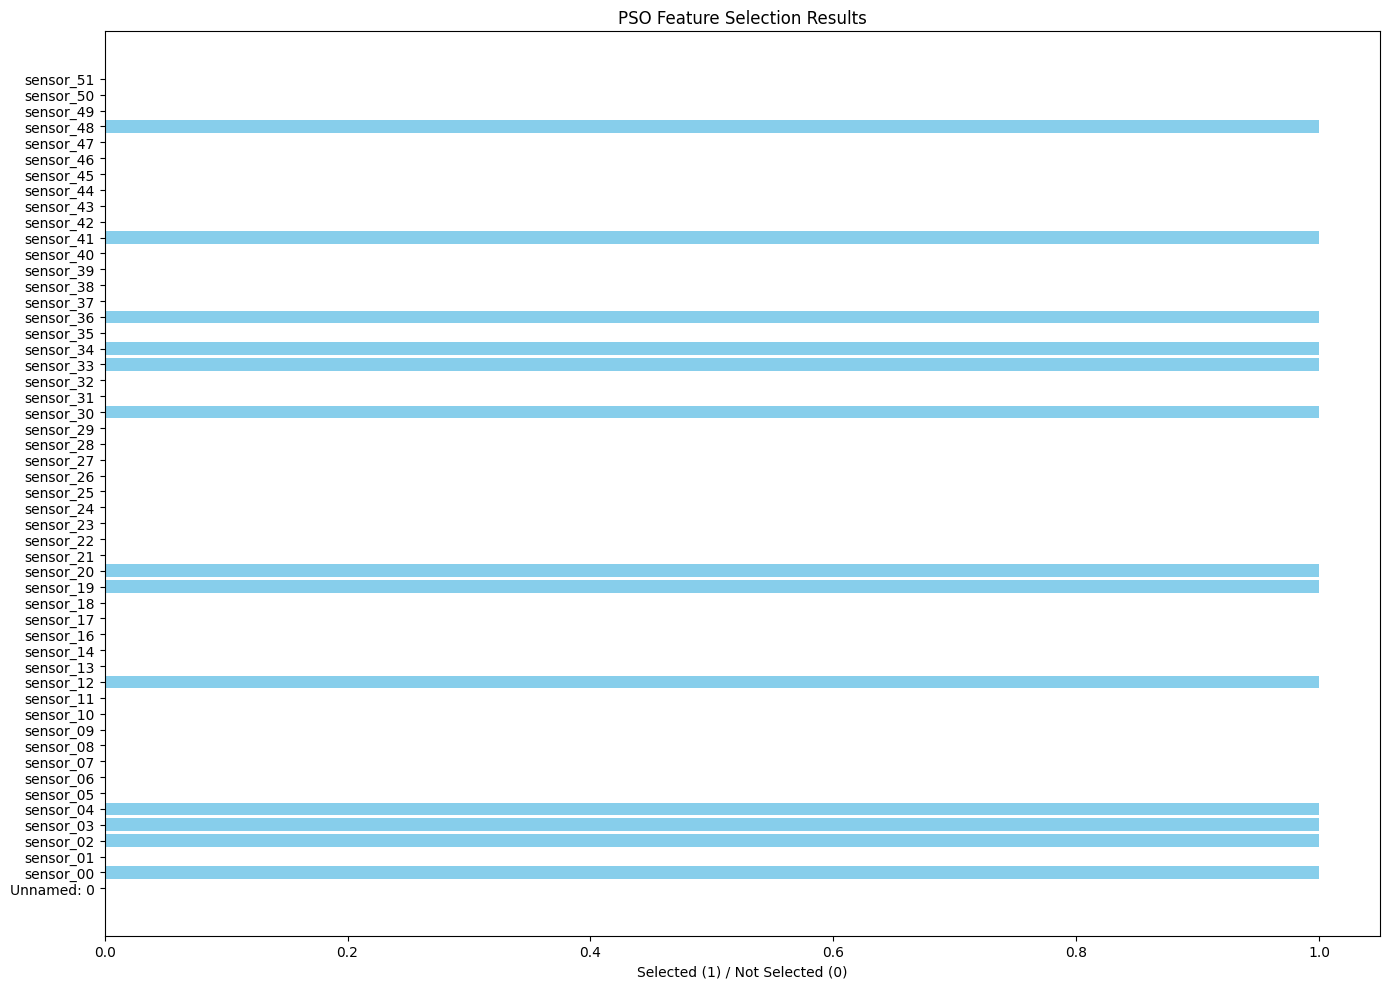

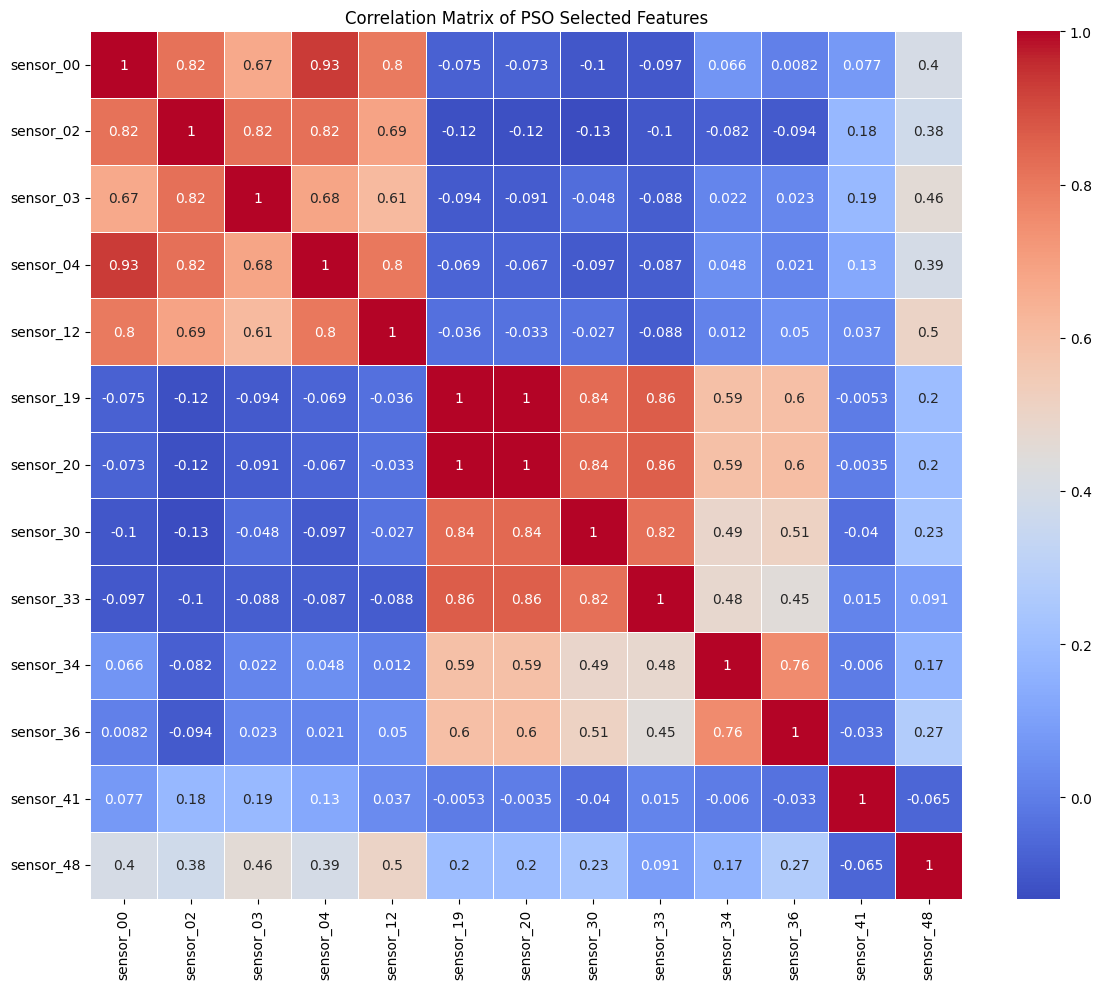

In [23]:
# Create visualization for the results
plt.figure(figsize=(12, 6))

# Plot model performance comparison
models_list = list(models.keys())
original_r2 = [original_results[name]['R2'] for name in models_list]
reduced_r2 = [reduced_results[name]['R2'] for name in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x - width/2, original_r2, width, label='Original Dataset')
plt.bar(x + width/2, reduced_r2, width, label='PSO Reduced Dataset')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.tight_layout()

# Plot PSO feature selection - showing top selected features importance
plt.subplot(1, 2, 2)
if len(selected_features) > 0:
    # Use Random Forest to estimate feature importance of selected features
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_pso, y_train)

    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot feature importance
    top_n = min(10, len(selected_features))
    plt.barh(range(top_n), importances[indices[:top_n]])
    plt.yticks(range(top_n), [selected_feature_names[i] for i in indices[:top_n]])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Selected Features by PSO')
else:
    plt.text(0.5, 0.5, "No features selected", ha='center', va='center')

plt.tight_layout()
plt.savefig('pso_results.png')
plt.show()

# Summary table
performance_summary = pd.DataFrame({
    'Original Dataset R²': original_r2,
    'PSO Reduced Dataset R²': reduced_r2,
    'R² Difference': np.array(reduced_r2) - np.array(original_r2),
    'Original Training Time (s)': [original_times[name] for name in models_list],
    'PSO Reduced Training Time (s)': [reduced_times[name] for name in models_list],
    'Time Savings (%)': [(1 - reduced_times[name]/original_times[name]) * 100 for name in models_list]
}, index=models_list)

print("\nPerformance Summary:")
print(performance_summary)

# Save results to CSV
performance_summary.to_csv('pso_performance_summary.csv')

# Feature visualization for PSO selected features
plt.figure(figsize=(14, 10))

# Visualize the distribution of selected vs non-selected features
selected_mask = np.zeros(n_features, dtype=bool)
selected_mask[selected_features] = True

# Create a bar chart showing which features were selected
plt.barh(range(n_features), selected_mask.astype(int), color='skyblue')
plt.yticks(range(n_features), feature_names)
plt.xlabel('Selected (1) / Not Selected (0)')
plt.title('PSO Feature Selection Results')
plt.tight_layout()
plt.savefig('pso_feature_selection.png')
plt.show()

# Create a correlation matrix of selected features
if len(selected_features) > 1:
    plt.figure(figsize=(12, 10))
    selected_data = X_imputed_df.iloc[:, selected_features]
    corr = selected_data.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of PSO Selected Features')
    plt.tight_layout()
    plt.savefig('pso_feature_correlation.png')
    plt.show()